In [1]:
import sys
import torch
from torch import nn, optim
import torchvision
from matplotlib import pyplot as plt

sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample")

from src.network import LikApprox
from src.network import PredictApprox
from src.weight_distribution.Diagonal import Diagonal
from src.weight_distribution.Full import FullCovariance
from src.network.Classification import LLVIClassification

sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI")
from BNN_Comparison.TyXe import tyxe
from pyro import distributions as pyro_dist
import pyro
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 14,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
%matplotlib inline
from datetime import datetime
import pandas as pd
import math

In [2]:
batch_size_train = 32
batch_size_test = 32
filepath = "/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample/datasets/Classification"
dataset = torchvision.datasets.MNIST(filepath, train=True, download=False,
                            transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ]))
train_size = int(0.5 * len(dataset))
rest_size = len(dataset) - train_size                            
dataset, rest_dataset = torch.utils.data.random_split(dataset, [train_size, rest_size])
train_loader = torch.utils.data.DataLoader(dataset,
  batch_size=batch_size_train, shuffle=True)
n_datapoints = batch_size_train * len(train_loader)

/opt/homebrew/Caskroom/miniforge/base/envs/DeepLearning/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1635217266490/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(filepath, train=False, download=False,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ])),
batch_size=batch_size_test, shuffle=True)
n_test_datapoints = batch_size_test * len(test_loader)

In [4]:
tracking_cols = ["Epoch time", "NLL"]

In [5]:
class EpochTimeStamp:
    def __init__(self):
        self.epoch_start_time = datetime.now()
    
    def get_delta(self):
        return (datetime.now() - self.epoch_start_time).total_seconds()

    def update(self):
        self.epoch_start_time = datetime.now()

## Model

In [6]:
class CNN(nn.Module):
    def __init__(self, out_dim=10, optimizer=optim.Adam, **optim_kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 50)
        self.fc3 = nn.Linear(50, out_dim, bias=False)
        self.optimizer: optim = optimizer(self.parameters(), **optim_kwargs)
        self.nonll = torch.sigmoid # nonlinear layer

    def forward(self, x):
        x = self.pool(self.nonll(self.conv1(x)))
        x = self.pool(self.nonll(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.nonll(self.fc1(x))
        x = self.nonll(self.fc2(x))
        x = self.fc3(x)
        return x 


class VICNN(nn.Module):
    def __init__(self, feature_dim=50, optimizer=optim.Adam, **optim_kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, feature_dim)
        self.optimizer: optim = optimizer(self.parameters(), **optim_kwargs)
        self.nonll = torch.sigmoid # nonlinear layer

    def forward(self, x):
        x = self.pool(self.nonll(self.conv1(x)))
        x = self.pool(self.nonll(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.nonll(self.fc1(x))
        x = self.nonll(self.fc2(x))
        return x

In [11]:
# general parameters
feature_dim = 50
out_dim = 10
weight_decay = 1e-3
lr = 1e-3
tau = 1
prior_log_var = math.log(1/(weight_decay * n_datapoints))
epochs=5
train_samples_full = 1
train_samples_ll = 1
test_samples = 10

## Last-layer Model

In [12]:
torch.manual_seed(3)
ll_vifeature_extractor = VICNN(lr=lr, weight_decay=weight_decay, feature_dim=feature_dim)

dist = Diagonal(feature_dim, out_dim, lr=lr, init_log_var=-1)

llvi_net = LLVIClassification(feature_dim, out_dim, ll_vifeature_extractor, dist, prior_log_var=prior_log_var,
tau=tau, lr=lr)

In [13]:
@torch.no_grad()
def callback_fun(model, validation_set, n_datapoints, tracking_list, epoch_time_stamp: EpochTimeStamp):
    epoch_time = epoch_time_stamp.get_delta() # get epoch time
    total_loss = 0
    loss_metric = torch.nn.NLLLoss(reduction="mean")
    for data, target in validation_set:
        prediction = model(data, method=PredictApprox.MONTECARLO, samples=test_samples)
        prediction = torch.log(prediction) # need logsoftmax for nll loss
        total_loss += loss_metric(prediction, target).item()
    total_loss/= n_datapoints
    
    tracking_list.loc[len(tracking_list)] = [epoch_time, total_loss]
    epoch_time_stamp.update() # update start time for new epoch


In [14]:
ll_tracking = pd.DataFrame(columns=tracking_cols)
ll_epoch_start = EpochTimeStamp()
llvi_validation_fun = lambda x: callback_fun(llvi_net, test_loader, n_test_datapoints, ll_tracking, ll_epoch_start)
llvi_net.train_model(train_loader, epochs=epochs, n_datapoints=n_datapoints, method=LikApprox.MONTECARLO, callback=llvi_validation_fun, samples=train_samples_ll);

prediction_loss:0.2 kl_loss:0.38: 100%|██████████| 5/5 [00:47<00:00,  9.55s/it] 


## Full layer model

In [21]:
torch.manual_seed(1)
full_net = CNN(lr=lr, weight_decay=weight_decay, out_dim=out_dim)
prior = tyxe.priors.IIDPrior(pyro_dist.Normal(0, math.exp(prior_log_var)))
kl_div_scaling_factor=1/tau
likelihood = tyxe.likelihoods.Categorical(n_datapoints * kl_div_scaling_factor)
inference = tyxe.guides.AutoNormal
full_bnn = tyxe.VariationalBNN(full_net, prior, likelihood, inference)

In [22]:
full_vi_tracking = pd.DataFrame(columns=tracking_cols)

@torch.no_grad()
def full_layer_val_fun(_, epoch, elbo, epoch_time_stamp: EpochTimeStamp):
    epoch_time = epoch_time_stamp.get_delta()
    print(f"Epoch {epoch}, ELBO loss {elbo} ", end="\r")
    total_loss = 0
    loss_metric = torch.nn.NLLLoss(reduction="mean")
    for data, target in test_loader:
        prediction = full_bnn.predict(data, num_predictions=test_samples)
        prediction = torch.log_softmax(prediction, dim=-1)
        total_loss += loss_metric(prediction, target).item()
    total_loss/= n_test_datapoints
    full_vi_tracking.loc[len(full_vi_tracking)] = [epoch_time, total_loss]
    epoch_time_stamp.update()
    

In [20]:
optim = pyro.optim.Adam({"lr": 1e-3})
epochs=5
full_epoch_start = EpochTimeStamp()
full_layer_callback = lambda x,y,z: full_layer_val_fun(x,y,z, full_epoch_start)
with tyxe.poutine.local_reparameterization():
    full_bnn.fit(train_loader, optim, num_epochs=epochs, callback=full_layer_callback, num_particles=train_samples_full)

KeyboardInterrupt: 

### MSE vs Time

(0.0, 0.25)

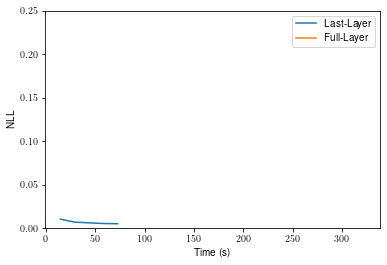

In [35]:
fig, axs = plt.subplots()
axs.plot(ll_tracking["Epoch time"].cumsum(), ll_tracking["NLL"], label="Last-Layer")
axs.plot(full_vi_tracking["Epoch time"].cumsum(), full_vi_tracking["NLL"], label="Full-Layer")
axs.legend()
axs.set_xlabel("Time (s)")
axs.set_ylabel("NLL")
axs.set_ylim(0, 0.25)

### MSE vs Epoch

(0.0, 0.25)

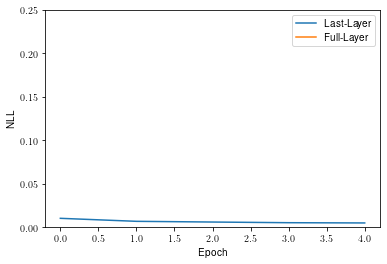

In [36]:
fig, axs = plt.subplots()
axs.plot(list(range(len(ll_tracking))), ll_tracking["NLL"], label="Last-Layer")
axs.plot(list(range(len(full_vi_tracking))), full_vi_tracking["NLL"], label="Full-Layer")
axs.legend()
axs.set_xlabel("Epoch")
axs.set_ylabel("NLL")
axs.set_ylim(0, 0.25)